## Dati Satellite Sentinel-1 (SAR bands)

In [1]:
from path import Path
import arrow
import json
import pytz
import time
from pprint import pprint
from tqdm.notebook import tqdm
import re, os, collections, itertools, uuid, logging
import tempfile

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely

plt.rcParams['figure.figsize'] = (15, 5) # bigger plots
plt.style.use('fivethirtyeight')
%matplotlib inline
%precision 4

'%.4f'

In [2]:
helper_dir = str(Path('..').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s1, bands_s1_float, bands_s1_float_dem, bands_srtm, download_image
from leak_helpers.visualization import imshow_bands

In [3]:
# # Non voglio stampare i Warning
# import warnings
# warnings.filterwarnings("ignore")

# Load leaks

Load the leaks from a geojson file and make sure they have unique fields REPO_Date and workorderid (see asserts below)

In [4]:
# load 
root = "../../../ricerca_perdite"
leaks = gpd.read_file(root+"/data/leak_dataset/leaks.geojson")

leaks_datas = [leaks]

leaks_datas

[          id  anno civico       comune  \
 0          0  2015    137        AULLA   
 1          1  2015      8        AULLA   
 2          2  2015    110        AULLA   
 3          3  2015    snc        aulla   
 4          4  2015    snc        aulla   
 ...      ...   ...    ...          ...   
 33179  33179  2021   None  GIUNCUGNANO   
 33180  33180  2021   None    MOLAZZANA   
 33181  33181  2021   None    MASSAROSA   
 33182  33182  2021   None    MASSAROSA   
 33183  33183  2021   None    MASSAROSA   
 
                                              description  diametro  \
 0                               Perdita acqua dalla rete      63.0   
 1                               Perdita acqua dalla rete      40.0   
 2                               Perdita acqua dalla rete      90.0   
 3      perdita rete idrica su strada provinciale in l...      90.0   
 4       perdita rete idrica in loc albiano via molinetti      63.0   
 ...                                                  ..

In [5]:
# join them all, with primary columns and random metadata
primary_cols = ['workorderid','reportdate','geometry']
leaks = gpd.GeoDataFrame(pd.concat([leaks_data[primary_cols] for leaks_data in leaks_datas]), crs="EPSG:4326")
leaks['metadata'] = np.concatenate([leaks_data.drop(primary_cols,1).to_dict('records') for leaks_data in leaks_datas])
leaks.index = leaks.workorderid
leaks

C:\Users\TRANFA~1.CAR\AppData\Local\Temp/ipykernel_7284/2551425569.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  leaks['metadata'] = np.concatenate([leaks_data.drop(primary_cols,1).to_dict('records') for leaks_data in leaks_datas])


,workorderid,reportdate,geometry,metadata
workorderid,,,,
430398,430398,2015-05-08T08:16:00+00:00,POINT (9.90141 44.17144),"{'id': '0', 'anno': 2015, 'civico': '137', 'co..."
454859,454859,2015-06-10T08:18:00+00:00,POINT (9.91343 44.17462),"{'id': '1', 'anno': 2015, 'civico': '8', 'comu..."
455210,455210,2015-06-11T09:09:00+00:00,POINT (9.90498 44.17221),"{'id': '2', 'anno': 2015, 'civico': '110', 'co..."
459545,459545,2015-06-18T06:00:56.737000+00:00,POINT (9.90778 44.17321),"{'id': '3', 'anno': 2015, 'civico': 'snc', 'co..."
467973,467973,2015-06-30T06:10:52.959999+00:00,POINT (9.91327 44.17462),"{'id': '4', 'anno': 2015, 'civico': 'snc', 'co..."
...,...,...,...,...
2725108,2725108,2021-10-21T14:50:35.837002+00:00,POINT (10.23105 44.20313),"{'id': '33179', 'anno': 2021, 'civico': None, ..."
2730580,2730580,2021-10-26T11:23:17.657000+00:00,POINT (10.41085 44.08091),"{'id': '33180', 'anno': 2021, 'civico': None, ..."
2746652,2746652,2021-11-08T15:39:00+00:00,POINT (10.36244 43.84858),"{'id': '33181', 'anno': 2021, 'civico': None, ..."


In [6]:
# limit leaks to the time and space where satellite data exists
print('before',len(leaks))

# limit it to after satelite came into service
leaks= leaks[pd.to_datetime(leaks.reportdate)>pd.Timestamp('2014-10-03', tz='UTC')] 

# # also limit them by location
# satellite_bounds = shapely.geometry.box(
#     # continentental us
#     minx = -124.7844079, # west long
#     miny =  24.7433195, # south lat
#     maxx = -66.9513812, # east long
#     maxy = 49.3457868, # north lat   
# )
# leaks = leaks[leaks.intersects(satellite_bounds)]
print('after',len(leaks))

before 33184
after 33183


## Params

Customise the values in the cell below

In [7]:
# params
bands = bands_s1 # list of satelite band names from earth engine
satellite = 'COPERNICUS/S1_GRD_FLOAT' # satelite name from earth engine
resolution_min = 10.0 # the lowest resolution on earth engine

# how many pixels hight and wide you image will be (centered on leak), should be odd, e.g. 25
pixel_length = 25.0

# you need to tweak this until you pass the "Test the distance need to get your rectangle" cell
fudge_distance_factor = -0.50

## Init

In [10]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook_name = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [11]:
notebook_name

'scraping_earth_engine_s1_float'

In [12]:
# constant params, probobly don't change
time_before = 6*60*60
time_after = 21*24*60*60
crs_grid = 3857 # keep this as auxilary sphere, this is the CRS the downloaded images will be in

# init
## init directories
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
temp_dir = Path(root+'/data/scraped_satellite_images/'+satellite.replace("/","_")+'/tmp/')
output_dir = Path(root+'/data/scraped_satellite_images/'+satellite.replace("/","_"))
cache_dir = Path(output_dir+'/cache')
output_dir.makedirs_p()
temp_dir.makedirs_p()
cache_dir.makedirs_p()

## init logger
logger = logging.getLogger(notebook_name)
# logger.setLevel(logging.WARN)

temp_dir, output_dir, cache_dir

(Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/tmp/'),
 Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT'),
 Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache'))

In [13]:
# # record cofig in a json file
# metadata = dict(
#     notebook_name=notebook_name,
#     satellite=satellite,
#     time_before=time_before,
#     time_after=time_after,
#     pixel_length=pixel_length,
#     resolution_min=resolution_min,
#     bands=bands,
#     ts=ts,
#     crs_grid=crs_grid,
#     cache_dir=str(cache_dir),
#     temp_dir=str(temp_dir),
#     output_dir=str(output_dir),
# )
# metadata_file = output_dir.joinpath('script_metadata.json')
# json.dump(metadata, open(metadata_file,'w'))

# Earth Engine

## Steps:
- first need to apply for an account
- Setup instructions [here](https://developers.google.com/earth-engine/python_install#setting-up-authentication-credentials)

## Refs/examples:
- api https://developers.google.com/earth-engine/
- code examples https://code.earthengine.google.com/
- sentinel1 https://developers.google.com/earth-engine/sentinel1
    - `ee.ImageCollection('satellite');`
    - `ee.ImageCollection('COPERNICUS/S1_GRD');`
- keras and google earth https://github.com/patrick-dd/landsat-landstats

In [14]:
# test earth-engine setup
from oauth2client import crypt # should have not error
import ee
ee.Initialize() # should give no errors, if so follow instructions

# test
image = ee.Image(ee.ImageCollection(satellite).first())
info = image.getInfo()
info

{'type': 'Image',
 'bands': [{'id': 'HH',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [28690, 24380],
   'crs': 'EPSG:32649',
   'crs_transform': [25, 0, 121126.5406, 0, -25, 9304939.2309]},
  {'id': 'HV',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [28690, 24380],
   'crs': 'EPSG:32649',
   'crs_transform': [25, 0, 121126.5406, 0, -25, 9304939.2309]},
  {'id': 'angle',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [21, 23],
   'crs': 'EPSG:32649',
   'crs_transform': [-17767.3274,
    -10569.5338,
    751271.4878,
    10727.6023,
    -17439.3233,
    9066467.5081]}],
 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_EW_GRDH_1SDH_20141003T003636_20141003T003740_002658_002F54_ECFA',
 'version': 1554414365549632,
 'properties': {'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4',
  'SLC_Processing_facility_org': 'ESRIN',
  'SLC_Processing_facility_country': 'Italy',
  'GRD_Post_Processing_facility_org'

In [15]:
# orbit_numb = image.getInfo()["properties"]["relativeOrbitNumber_start"]
# orbit_prop = image.getInfo()["properties"]["orbitProperties_pass"]

# orbit_numb, orbit_prop

# Fetching images

For each point
- find the nearest image before the repair
- and the soonest image after repair
- save a part of each with metadata

Later will can filter, interpolate, read into numpy arrays, and save to hdf file

In [16]:
import dataset
cache_file = 'sqlite:///{}'.format(cache_dir.dirname().joinpath('cache.db'))
db = dataset.connect(cache_file)
cache_table = db.get_table('cached_ids', primary_id='workorderid')

def get_cached_ids():
    return set(row['workorderid'] for row in cache_table.distinct('workorderid'))

def init_cache(workorderid):
    """We will cache downloads in folders like 'id_after'"""
    if workorderid:
        try:
            cache_table.insert(dict(workorderid=workorderid))
        except:
            db.rollback()
        else:
            db.commit()
    return

#Aggiunge il workorderid per il quale ho già l'immagine della tabella
img_path = Path('../../data/scraped_satellite_images/'+satellite.replace("/","_")+'/cache/')
for i in os.listdir(img_path):
    init_cache(i.split('_')[0])

# Conta il set di workorderid già scaricati
print("Perdite già provate a scaricare:",len(get_cached_ids()))

Perdite già provate a scaricare: 33183


In [17]:
# # Cancella dati dalla tabella
# cache_table.delete()

# Conta il set di workorderid che mancano da provare a scaricare
leak_to_scrape = set(leaks.workorderid).difference(set(get_cached_ids()))

print("Perdite mancanti da provare a scaricare:",len(leak_to_scrape))

Perdite mancanti da provare a scaricare: 0


### Test the distance need to get your rectangle

Here we need to tweak `fudge_distance_factor` so that we get the image size of our choice. Start with zero and try -1, -0.5, -.25,0,0.25,0.5,0.75. This is to deal with rounding, projecting between CRS's etc. Don't worry the asserts below will yet you know when it's right.

Occasionaly the problem might be that the leak is at the edge of the image, giving a cropped image. Ignore these rare cases.

In [18]:
distance = resolution_min*(pixel_length/2.0+fudge_distance_factor)
distance

120.0000

In [19]:
import time
import traceback

cached_ids = get_cached_ids()


def get_image_for_leak(i, cached_ids=cached_ids):
    leak = leaks.loc[[i]]
    reportdate = arrow.get(leak.reportdate.values[0]).timestamp()
    
    # crappy way of recording that we tried this one
    workorderid = leak.workorderid.values[0]
    if workorderid in cached_ids:
        logger.info('Skipping cached download for leak id %s ',workorderid)
        return
    
    boundary = get_boundary(leak, distance=distance)
    
    # get image day before    
    sentinel1_before = (ee.ImageCollection(satellite)
                        .filterBounds(boundary)
                        .filterDate((reportdate-time_before)*1000,(reportdate+time_before)*1000)
                        .sort('system:time_start', opt_ascending=False) ) # first will be latest
    
    results = sentinel1_before.size().getInfo()
    if results<1:
        logger.info('Error no results for day before %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
    
    orbit_numb = ee.Image(sentinel1_before.first()).getInfo()["properties"]["relativeOrbitNumber_start"]
    orbit_prop = ee.Image(sentinel1_before.first()).getInfo()["properties"]["orbitProperties_pass"]
        
    # get image after the leak was repaired
    sentinel1_after = (ee.ImageCollection(satellite)
                       .filterBounds(boundary)
                       .filterDate((reportdate+time_after)*1000,(reportdate+time_after*2)*1000)
                       .filter(ee.Filter.eq('orbitProperties_pass', orbit_prop))
                       .filter(ee.Filter.eq('relativeOrbitNumber_start', orbit_numb))
                       .sort('system:time_start', opt_ascending=True) ) # first will be earliest
        
    results = sentinel1_after.size().getInfo()
    if results<1:
        logger.info('Error no results after the leak was repaired, id %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
    
    # get a 2nd image after the leak was repaired
    sentinel1_after2 = (ee.ImageCollection(satellite)
                       .filterBounds(boundary)
                       .filterDate((reportdate+time_after*2)*1000,(reportdate+time_after*3)*1000)
                       .filter(ee.Filter.eq('orbitProperties_pass', orbit_prop))
                       .filter(ee.Filter.eq('relativeOrbitNumber_start', orbit_numb))
                       .sort('system:time_start', opt_ascending=True) ) # first will be earliest
        
    results = sentinel1_after2.size().getInfo()
    if results<1:
        logger.info('Error no results for the 2nd image after the leak was reaired, id %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
        
    # download as save images    
    logger.info('results for %s', workorderid)
    image = ee.Image(sentinel1_before.first()).clip(boundary)
    name=str(workorderid)+'_before'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    # also save metadata so we can filter by date
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)

    image = ee.Image(sentinel1_after.first()).clip(boundary)
    name=str(workorderid)+'_after'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)
    
    image = ee.Image(sentinel1_after2.first()).clip(boundary)
    name=str(workorderid)+'_after2'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)
    
    cached_ids = init_cache(str(workorderid)) # so we know there where no results
        
    return

leak_to_scrape = set(leaks.workorderid).difference(set(cached_ids))
for i in tqdm(leak_to_scrape):
    try:
        get_image_for_leak(i)
    except urllib.error.HTTPError as e:
        print(i,e) # "HTTP Error 429: unknown"
        traceback.print_stack()
        if e.code == 429:
            print('sleep for 13s')
            time.sleep(13);
    except ee.ee_exception.EEException as e:
        print(i,e) # "Earth Engine memory capacity exceeded."
        traceback.print_stack()
        ee.Initialize()
    except zipfile.BadZipFile as e:
        print(i,e) # "File is not a zip file"
        traceback.print_stack()
    except Exception as e:
        print(i,e)
        traceback.print_stack()

0it [00:00, ?it/s]

# Load Tiffs to Arrays

  0%|          | 0/33183 [00:00<?, ?it/s]

C:\Users\TRANFA~1.CAR\AppData\Local\Temp/ipykernel_7284/2393238685.py:78: ShapelyDeprecationWarning: The 'almost_equals()' method is deprecated and will be removed in Shapely 2.0
  assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'


../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/918168_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/918168_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/918168_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 525902


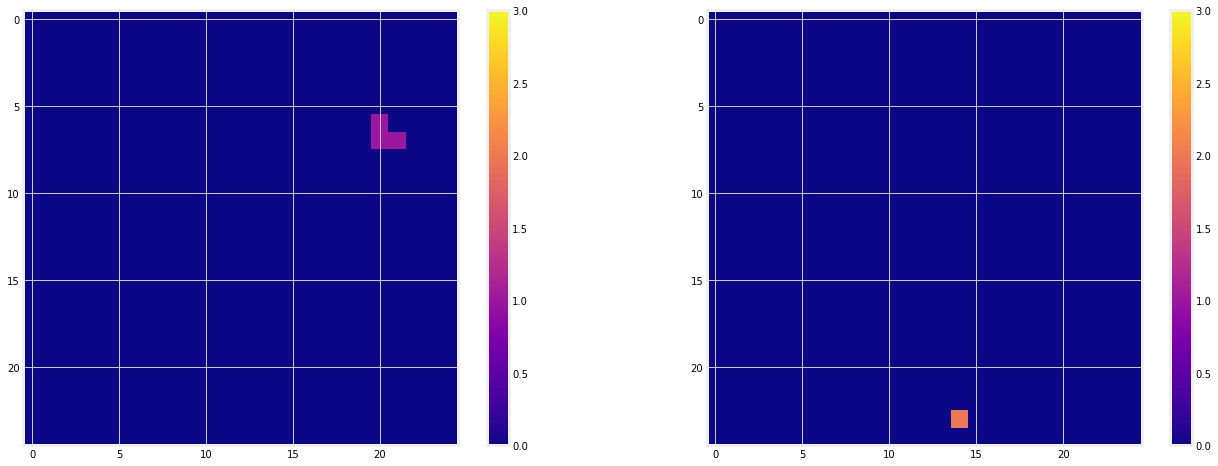

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1050402


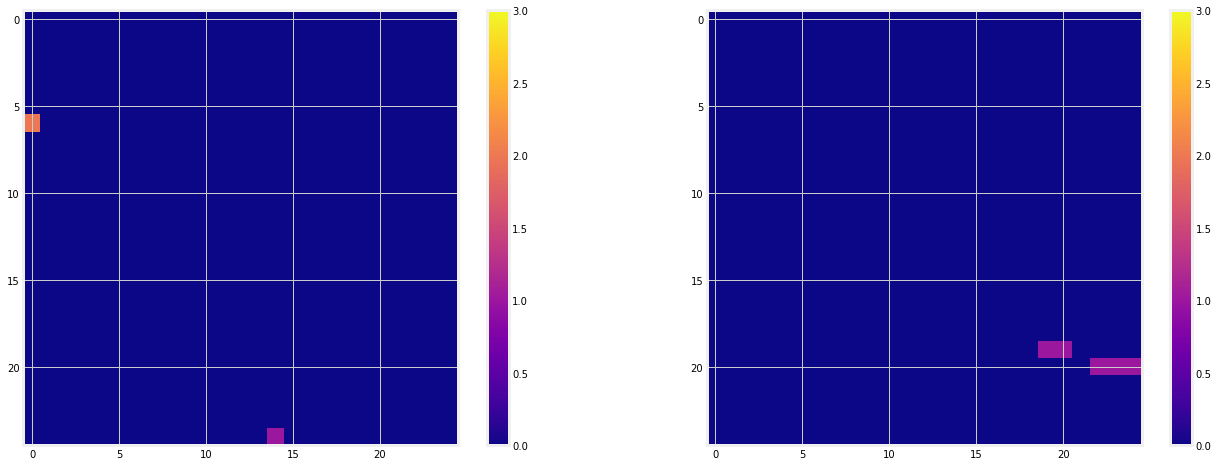

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1837521_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1837521_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1837521_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 790297


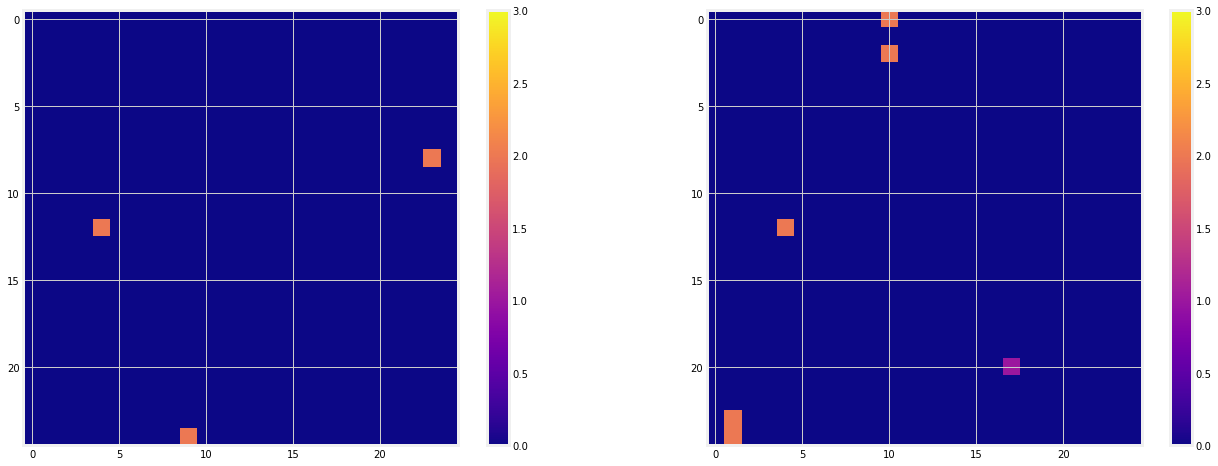

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1448848_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1448848_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1448848_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1057484


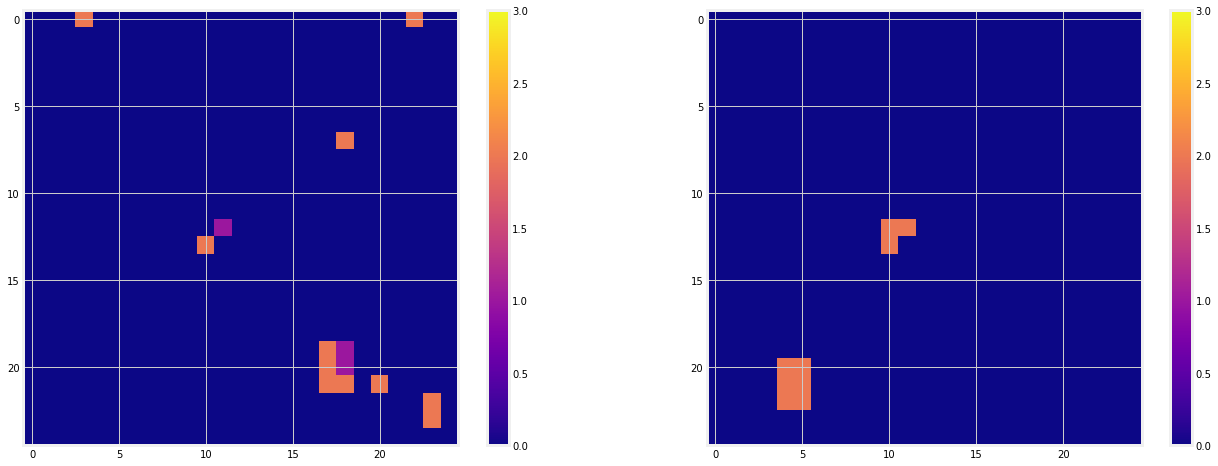

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2633035_after2_3857_10.0 leak location should be inside image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2633035_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2633035_before_3857_10.0 leak location should be inside image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1323731_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1323731_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1323731_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPER

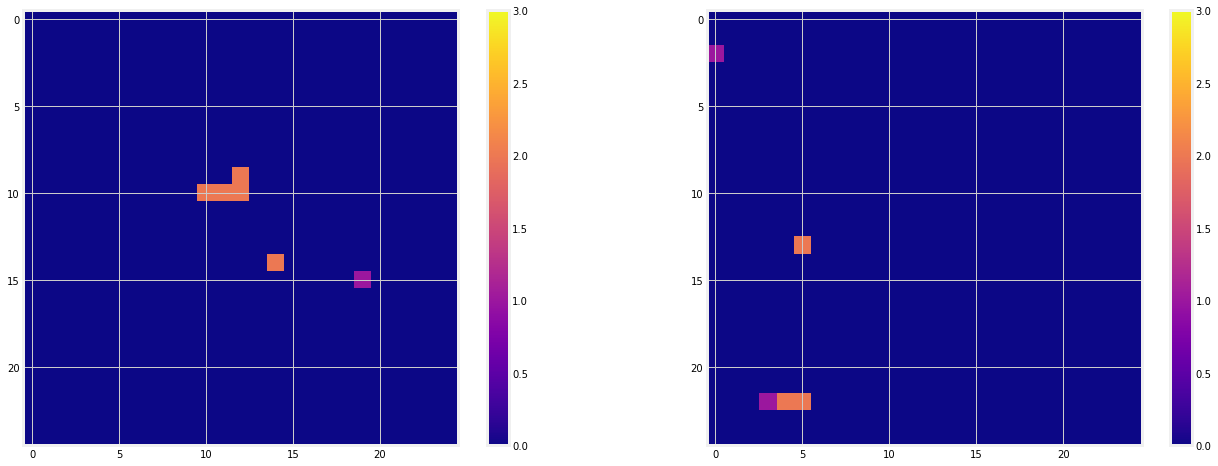

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1589771


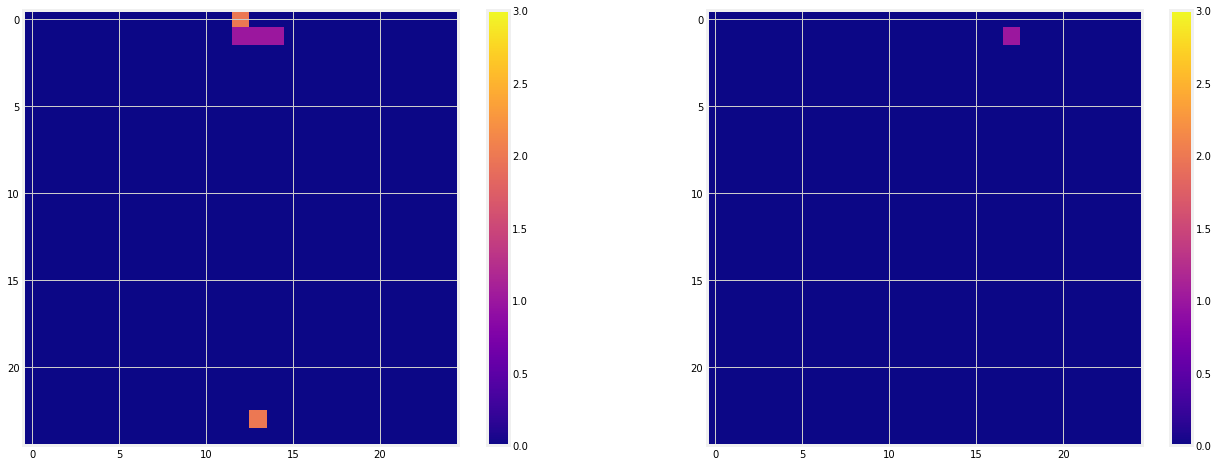

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1722277


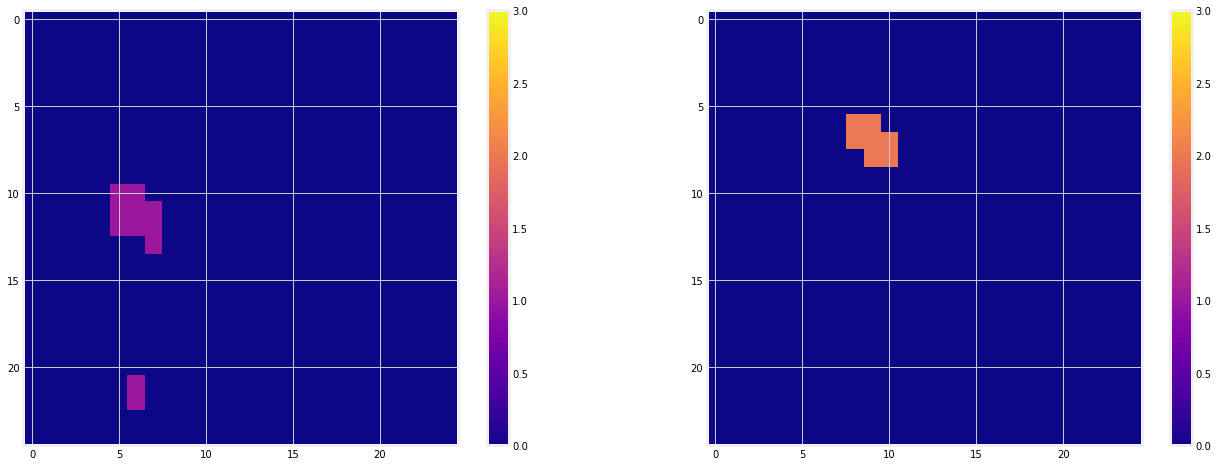

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1460691_after2_3857_10.0 leak should be near center of image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1460691_after_3857_10.0 leak location should be inside image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1460691_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 806860


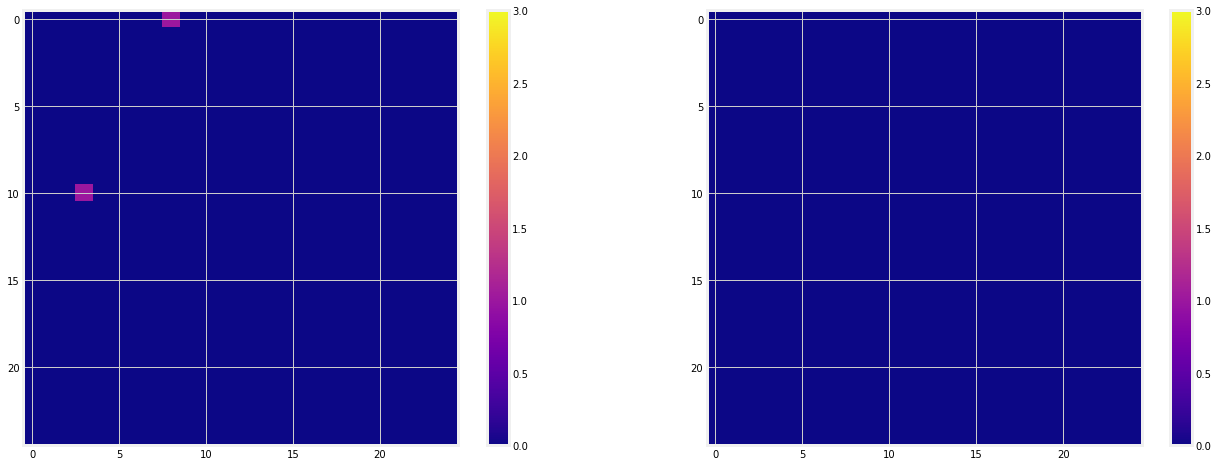

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1200461


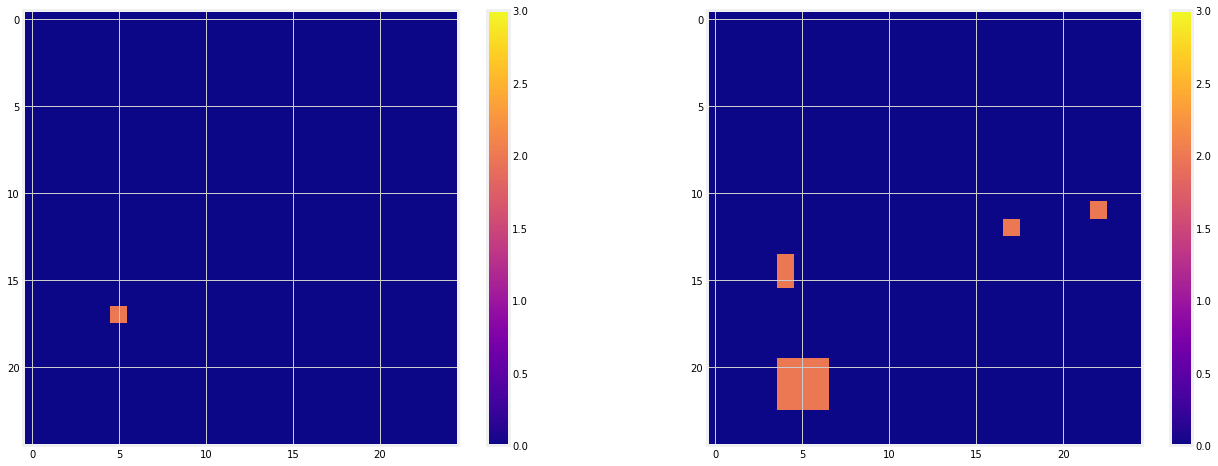

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1200680_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1200680_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1200680_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/418722_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/418722_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/418722_before_3857_10.0 leak location should be inside image
../../../ricerca_perdite/data/scraped_satellite_

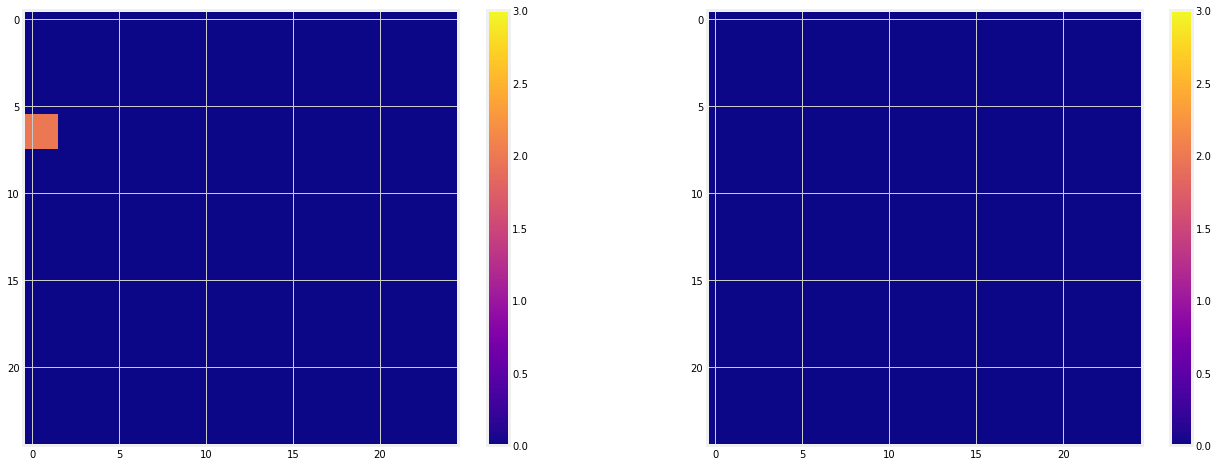

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 955344


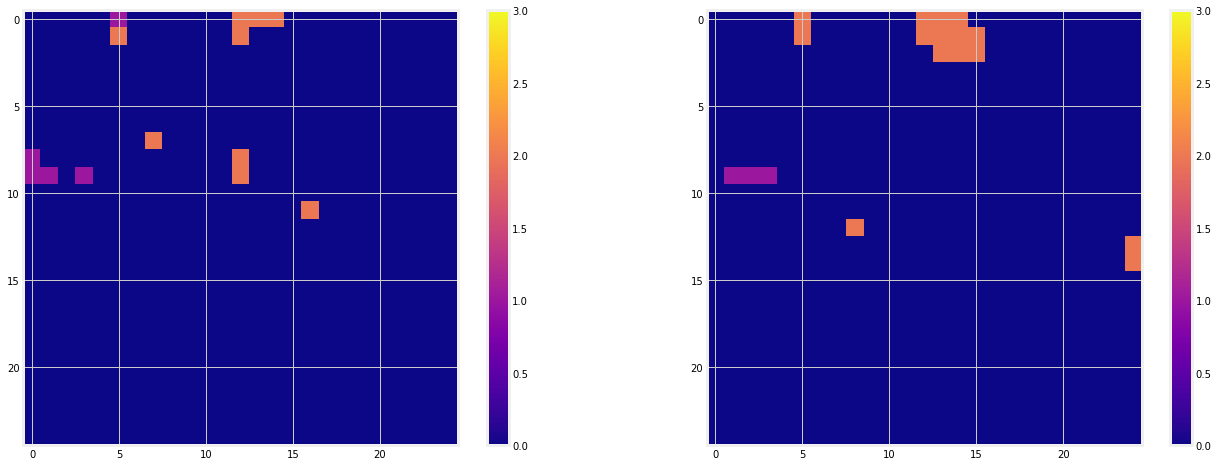

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1874327


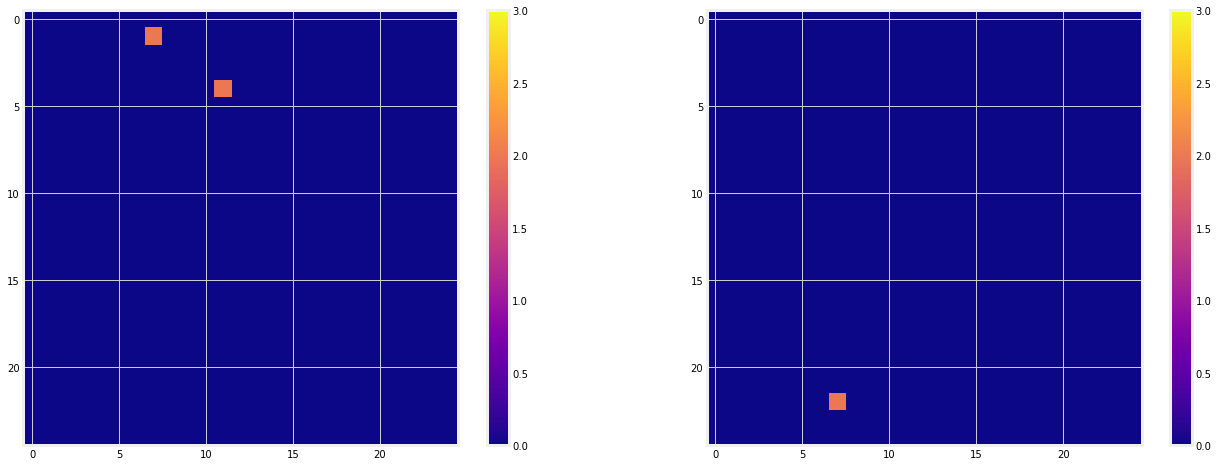

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1875147


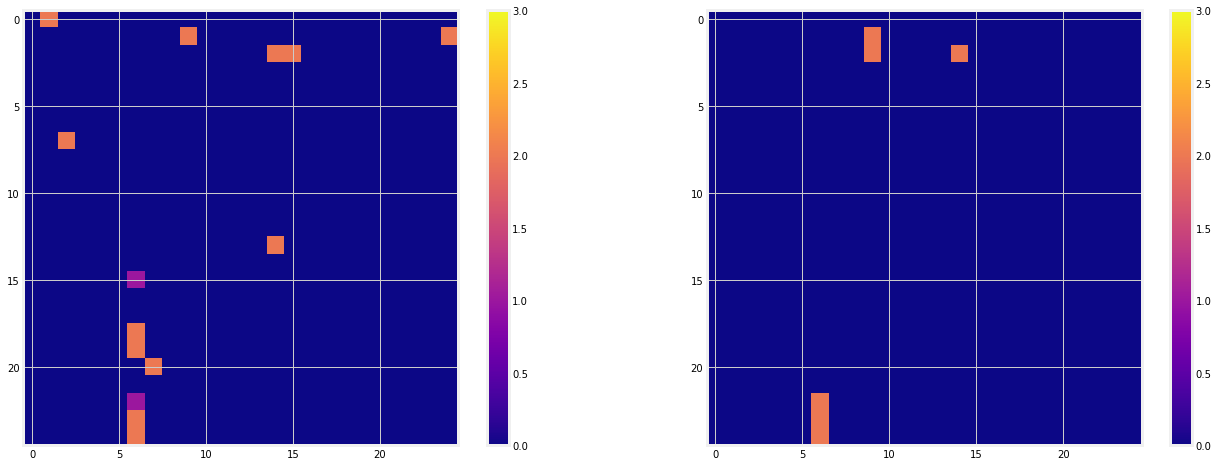

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1089789_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1089789_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1089789_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 2662759


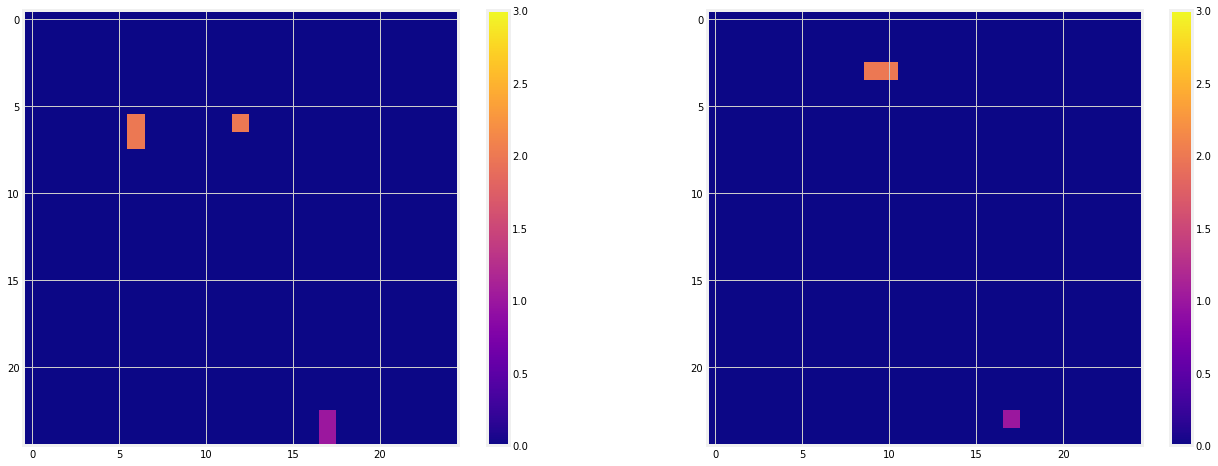

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1483952_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1483952_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1483952_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2142269_after2_3857_10.0 leak location should be inside image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2142269_after_3857_10.0 leak location should be inside image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2142269_before_3857_10.0 leak should be near center of image
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLO

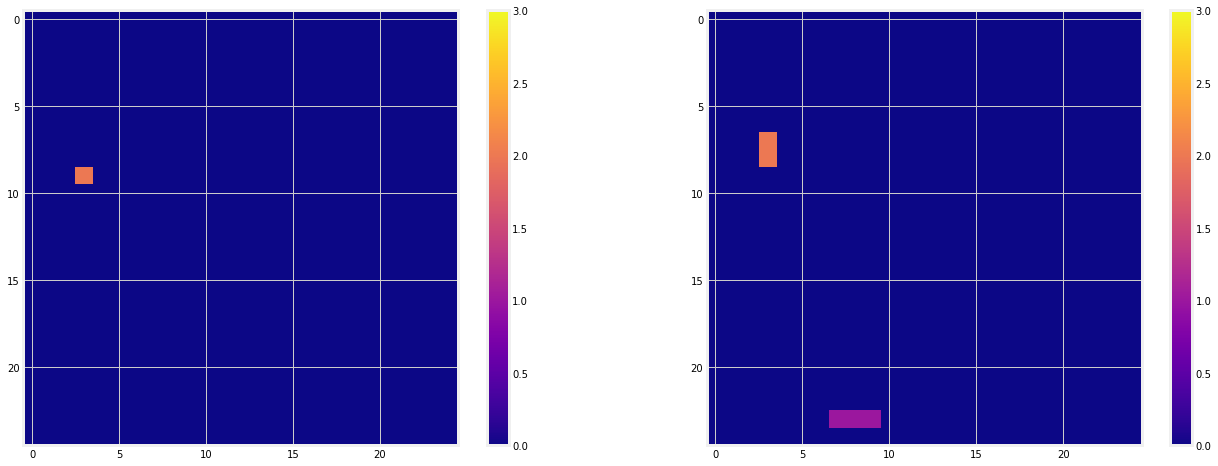

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1232802_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1232802_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1232802_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2281600_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2281600_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2281600_before_3857_10.0 leak should be near center of image
probabilità perdita Immagine con perdita vs Im

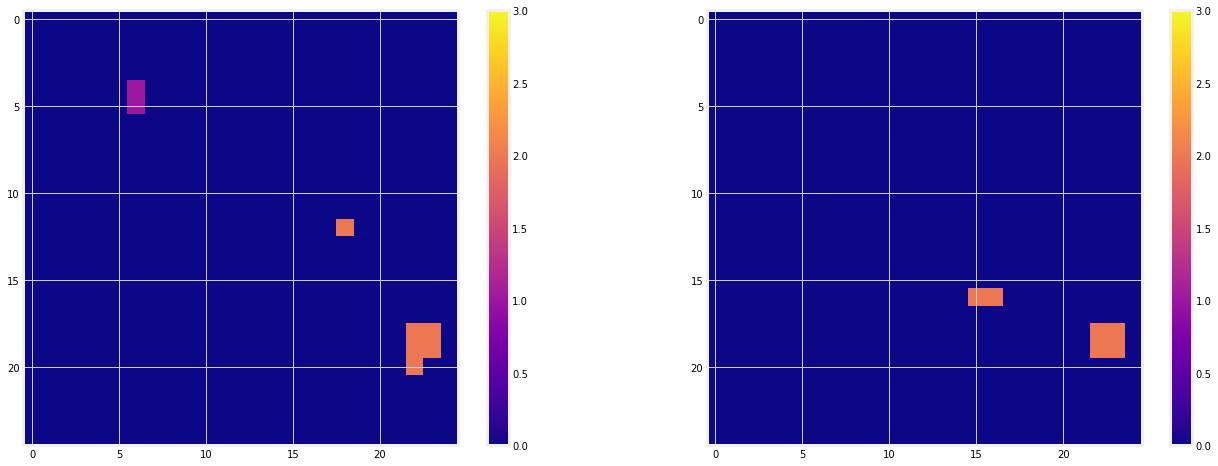

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/711969_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1106172_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1106172_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1106172_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1106269_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1106269_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/s

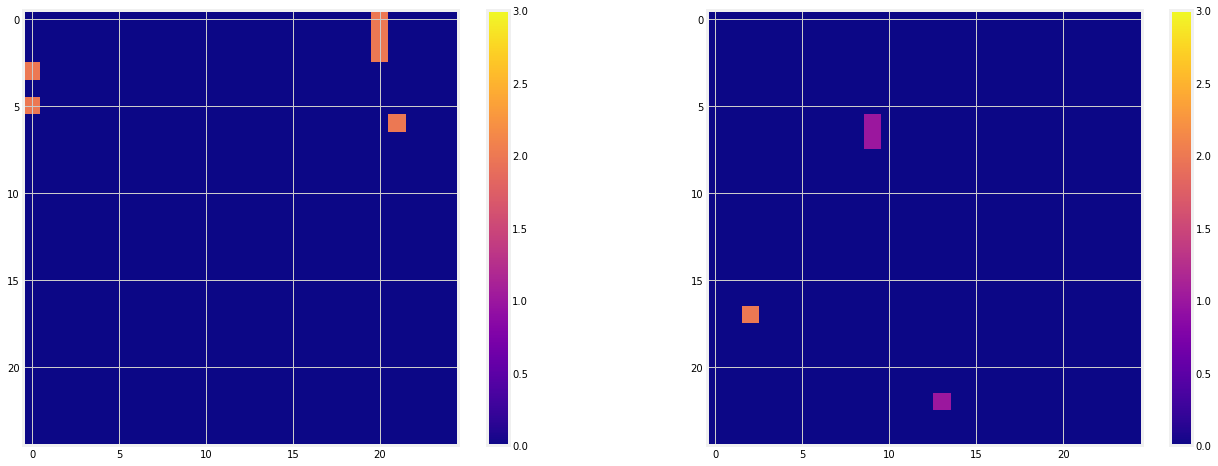

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/852466_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/852466_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/852466_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/721563_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1118416


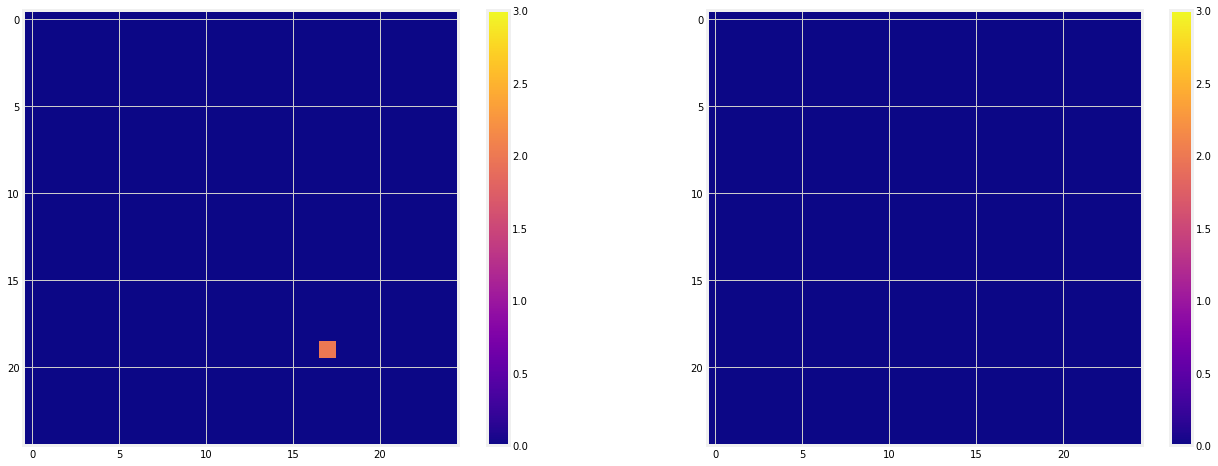

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 858414


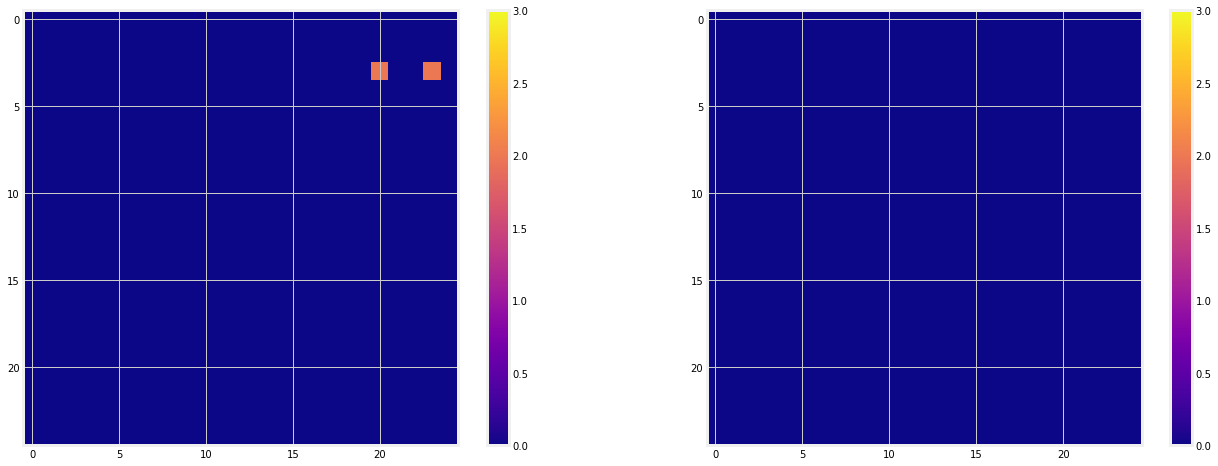

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1513919


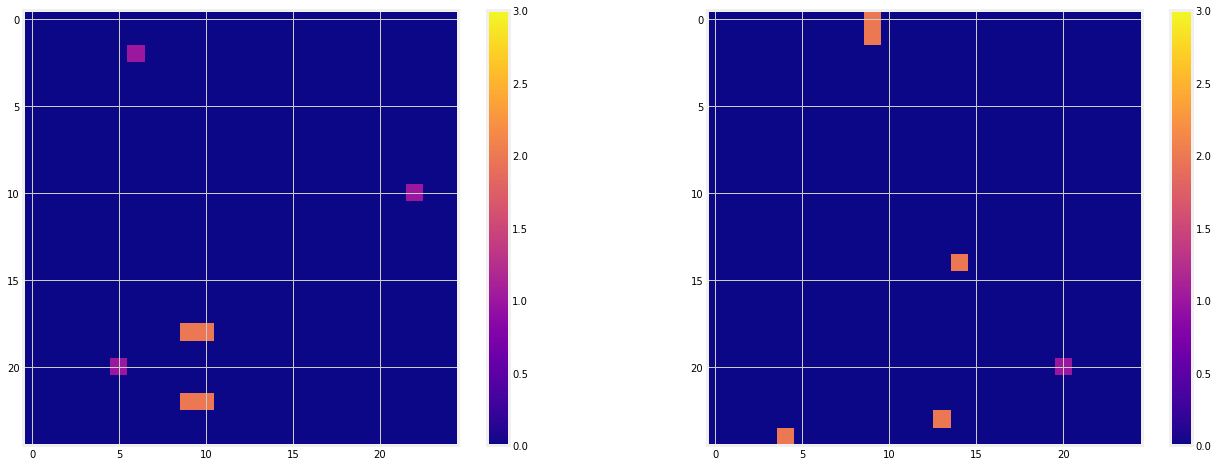

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 2693882


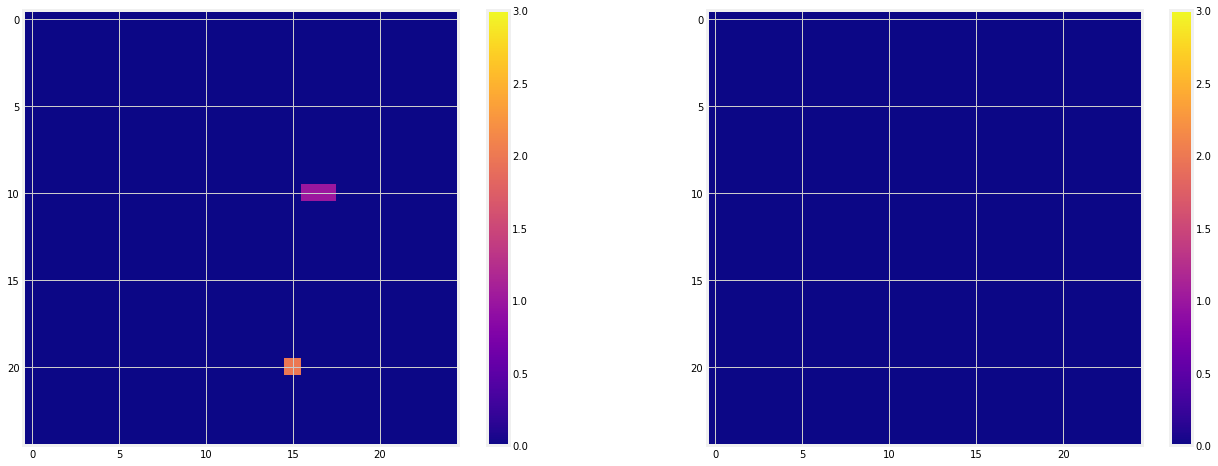

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1387432


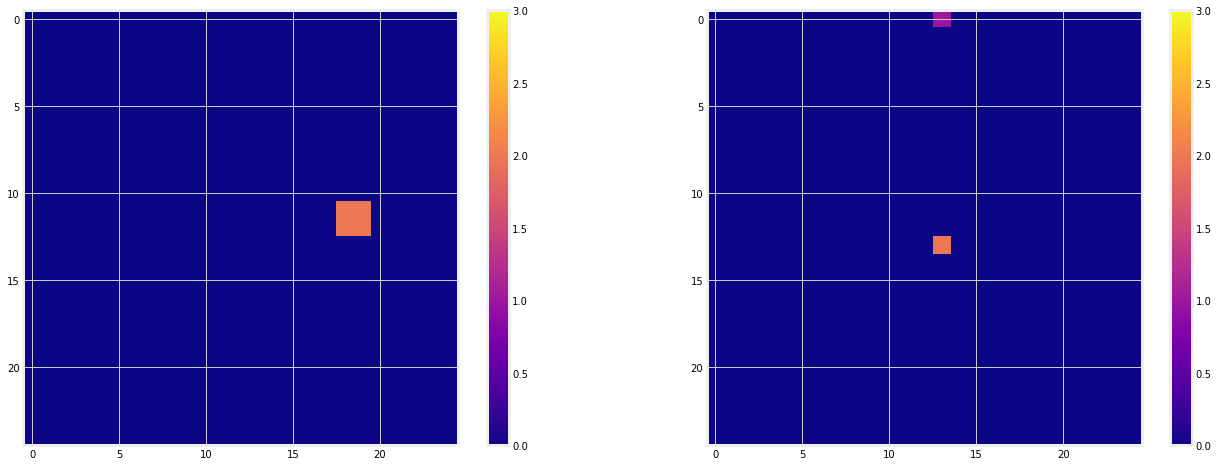

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1126815


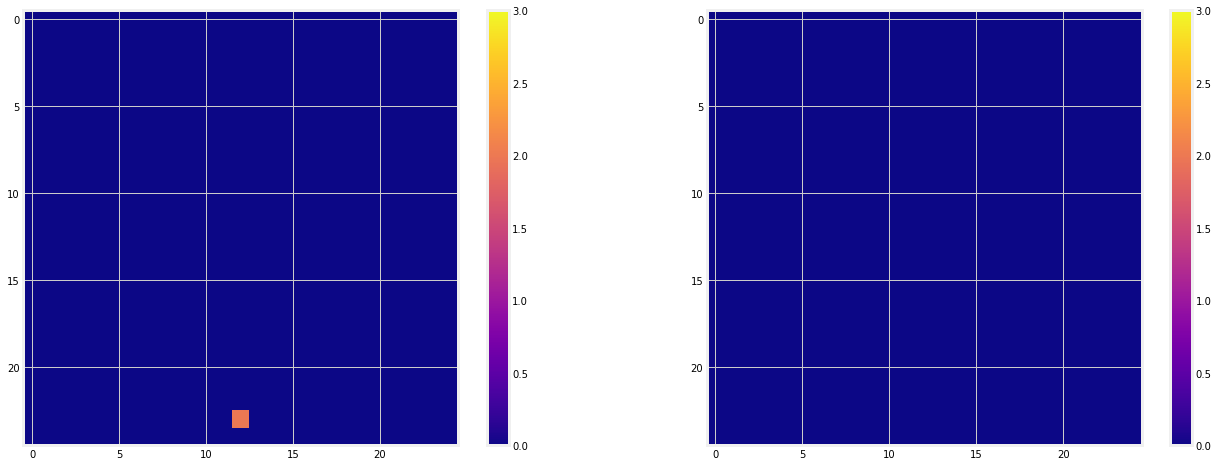

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 2310026


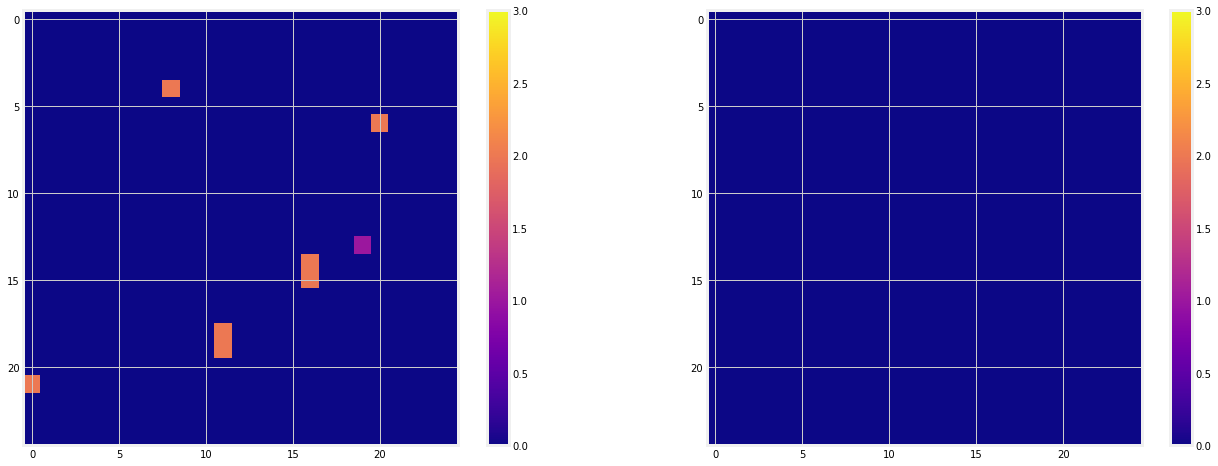

probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 2048345


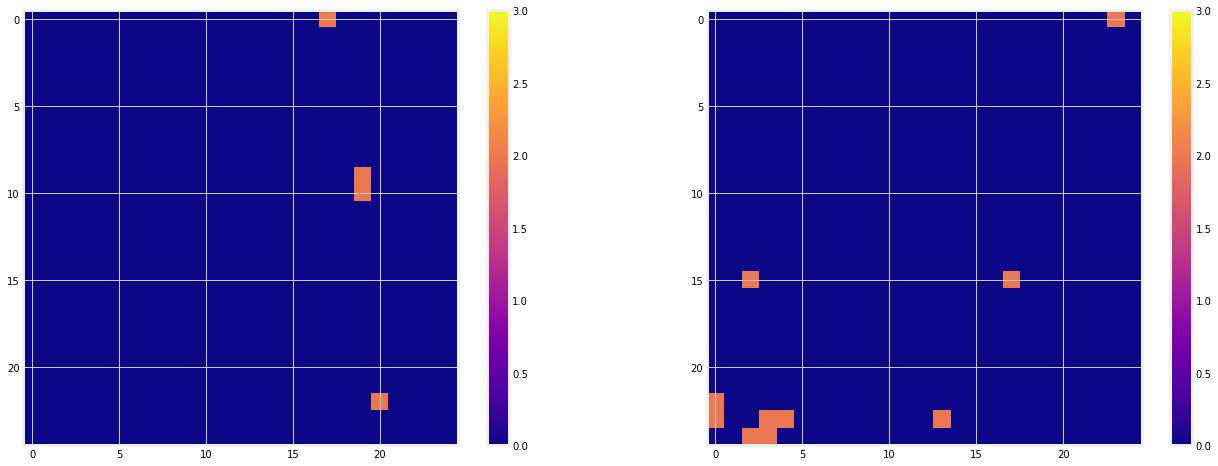

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/476936_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/476936_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/476936_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1133209_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1133209_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1133209_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con 

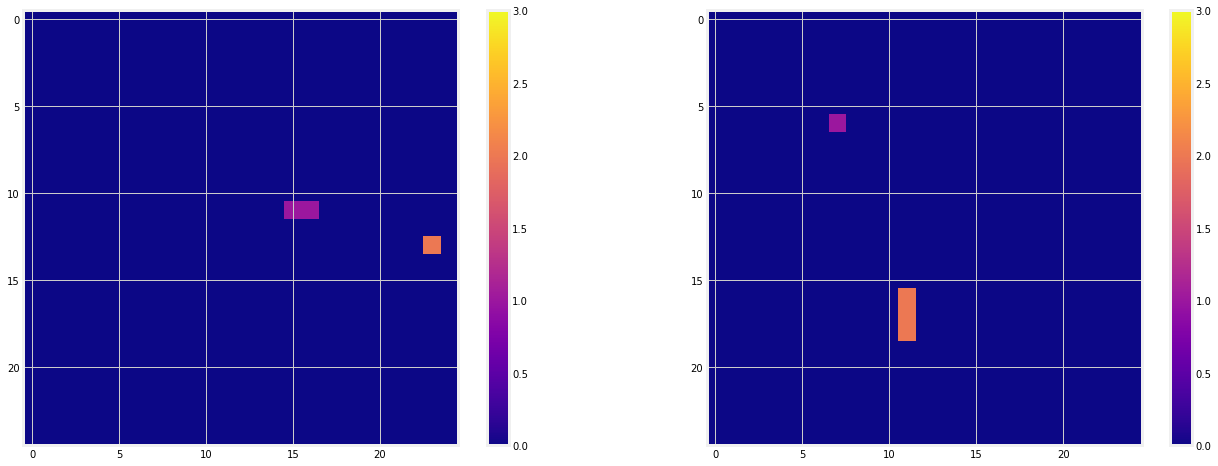

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/741071_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1005174


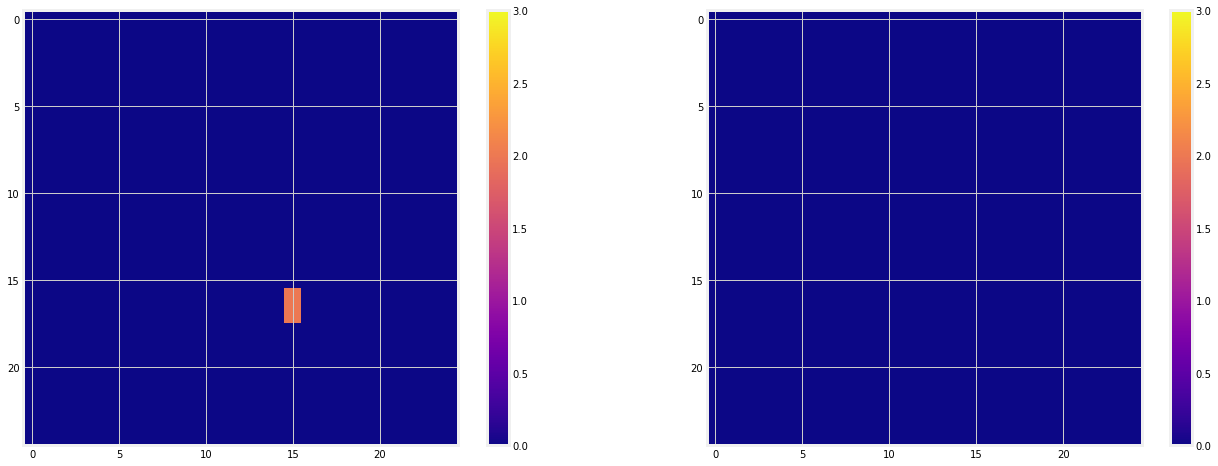

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/481614_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/481617_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1137245_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1137245_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1137245_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con perdita vs Immagine senza perdita. Id 1924640


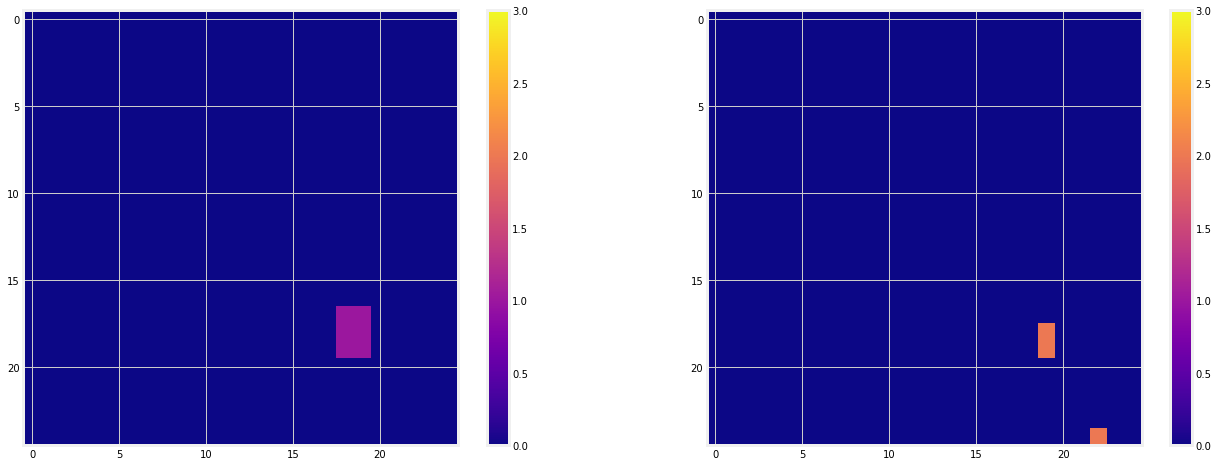

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/745259_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/745259_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/745259_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2451441_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2451441_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2451441_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
probabilità perdita Immagine con 

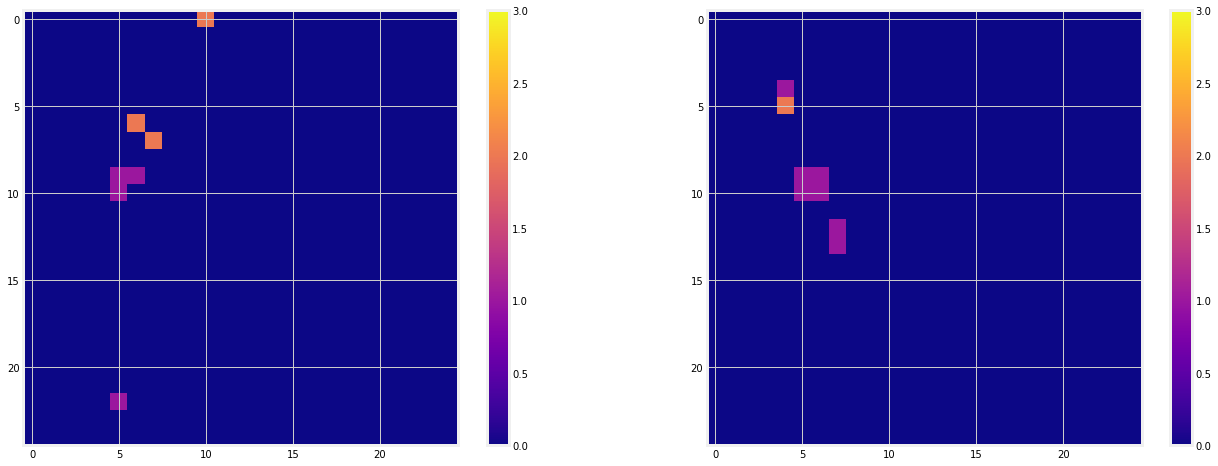

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1404638_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1404638_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1404638_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2717453_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2717453_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/2717453_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/

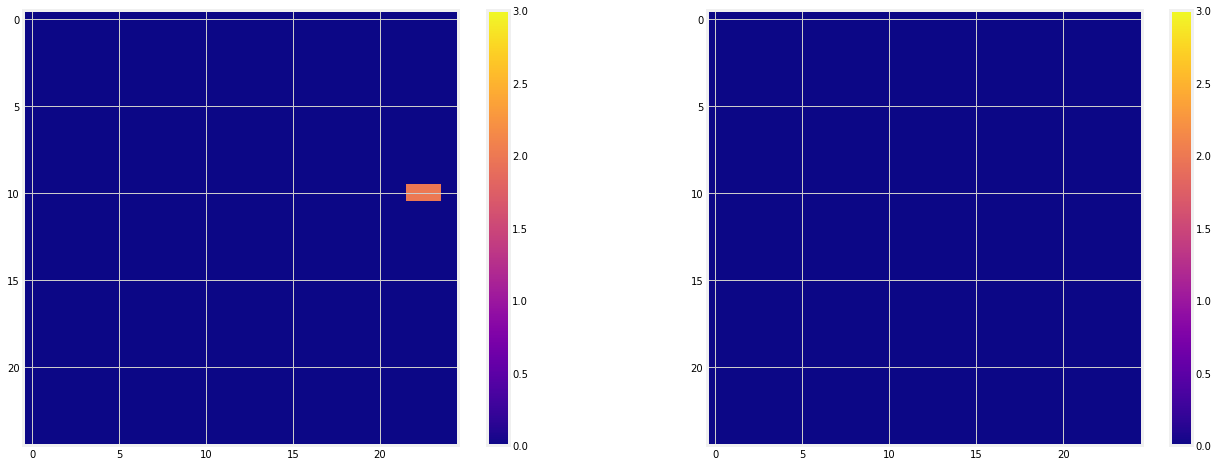

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1161126_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1161126_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1161126_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1161152_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1161152_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1161152_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/

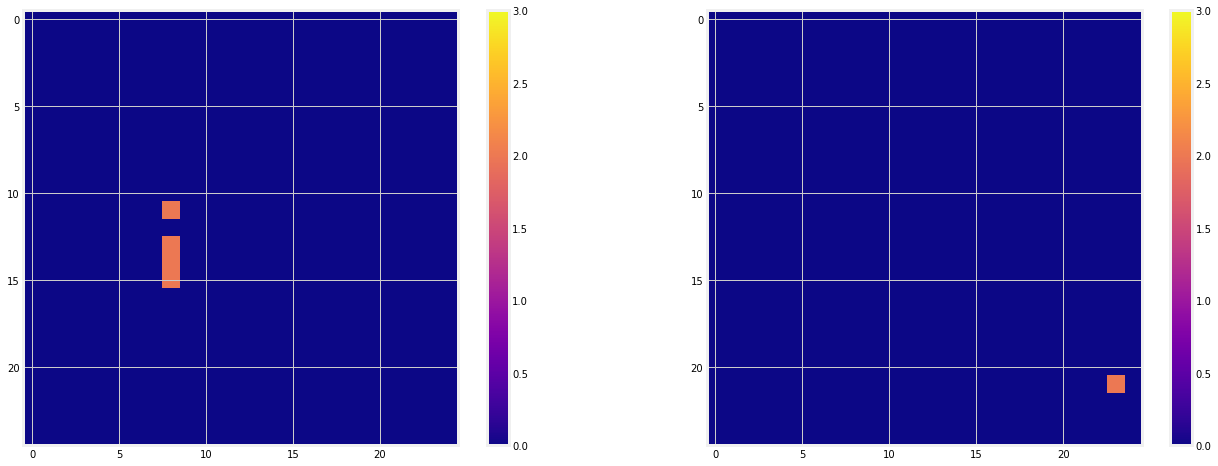

../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1431449_after2_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1431449_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/1431449_before_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/776668_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/776703_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT/cache/776710_after_3857_10.0 Non devono esserci valori nulli sulle bande VV e VH
../../../ricerca_perdite/data/scrap

(7378, 29627)

In [20]:
### Variabile per estrarre o meno anche i dati della quota e della pendenza
bands = bands_s1
dem_bands = True

### Nuova parte per creare i dataset delle differenze prima e dopo la perdita
### Non faccio img1 - img2 ma ne faccio il rapporto
import random
cached_ids = get_cached_ids()

from scipy.stats import norm, gamma, f, chi2
param_m = 4.4
alpha = 0.01


X = []
y = []
m = []
t = []
discarded=[]

for leak in tqdm(cached_ids):
    leak = str(leak)
    X_leak = np.ones(shape=(len(bands),int(pixel_length),int(pixel_length)))
    X_noleak = np.ones(shape=(len(bands),int(pixel_length),int(pixel_length)))
    metadata_leak = {}
    metadata_noleak = {}
    img_number = 0
    c1 = c2 = c3 = 0
    
    cdirs = [ cache_dir+'/'+leak+'_after2_3857_10.0', 
             cache_dir+'/'+leak+'_after_3857_10.0', 
             cache_dir+'/'+leak+'_before_3857_10.0' ]
    #print(leak, cdirs)
    for path in cdirs:
        if path.exists():
            files = [file.relpath(path) for file in path.listdir() if file.endswith('.tif')]
            #print(leak, files)
            if files:
                # check metadata
                try:
                    metadata = json.load(open(path.joinpath('metadata.json')))
                except (FileNotFoundError, ValueError) as e:
                    path.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))
                    if '_after_' in path: # also delete the before path
                        path_after = Path(path.replace('_after_','_before_'))
                        if path_after.isdir():
                            path_after.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))
                    if '_after2_' in path: # also delete the before path
                        path_after2 = Path(path.replace('_after2_','_before_'))
                        if path_after2.isdir():
                            path_after2.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))   
                    logger.error('Invalid metadata.json, deleted folder %s, please rerun scraping cell to rescrape this image', path)
                    continue

                # load data
                data = tifs2np(path,files,bands=bands)

                # check we don't have empty bands
                empty_bands = np.array([d.sum() for d in data])==0

                # lets check we didn't get the edge of an image
                bbox = np.array(metadata['image']['properties']['system:footprint']['coordinates'][0])
                loc = metadata['leak']['features'][0]['geometry']['coordinates']
                minx=bbox[:,0].min()
                maxx=bbox[:,0].max()
                miny=bbox[:,1].min()
                maxy=bbox[:,1].max()
                bbox_shp = shapely.geometry.box(
                    minx=minx,
                    maxx=maxx,
                    miny=miny,
                    maxy=maxy
                )
                loc_shp = shapely.geometry.Point(loc[0],loc[1])
                shapely.geometry.GeometryCollection([bbox_shp, loc_shp])
                try:
                    assert loc_shp.intersects(bbox_shp), 'leak location should be inside image'
                    assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'
                    assert (np.array([d.shape for d in data])==pixel_length).all(), 'image area should be the right amount of pixels'
                    assert not empty_bands.all(), 'should not have all bands empty'
                    assert np.any(data[(bands.index('VV'),bands.index('VH')),:] == 0) == False, 'Non devono esserci valori nulli sulle bande VV e VH'
                except Exception as exc:
                    print(path, exc)
                    discarded.append(path)
                else:
                    if '_before_' in path.basename() :
                        c1 = np.array(data)
                        X_leak = X_leak * np.array(data)
                        metadata_leak['before'] = metadata
                        t_leak = arrow.get(metadata['image']['properties']['system:time_start']/1000).timestamp()
                        img_number += 1
                    elif '_after_' in path.basename() :
                        c2 = np.array(data)
                        X_leak = X_leak / np.array(data)
                        X_noleak = X_noleak / np.array(data)
                        metadata_leak['after'] = metadata
                        metadata_noleak['after'] = metadata
                        img_number += 1
                    elif '_after2_' in path.basename() :
                        c3 = np.array(data)
                        X_noleak = X_noleak * np.array(data)
                        metadata_noleak['after2'] = metadata
                        t_noleak = arrow.get(metadata['image']['properties']['system:time_start']/1000).timestamp()
                        img_number += 1
    if img_number == 3:
        m2logq_leak = (np.log(c1[bands.index('VV')]*c1[bands.index('VH')])+np.log(c2[bands.index('VV')]*c2[bands.index('VH')])-2*np.log((c1+c2)[bands.index('VV')]*(c1+c2)[bands.index('VH')])+4*np.log(2*np.ones(shape=(int(pixel_length),int(pixel_length)))))*(-2*param_m)
        m2logq_noleak = (np.log(c3[bands.index('VV')]*c3[bands.index('VH')])+np.log(c2[bands.index('VV')]*c2[bands.index('VH')])-2*np.log((c3+c2)[bands.index('VV')]*(c3+c2)[bands.index('VH')])+4*np.log(2*np.ones(shape=(int(pixel_length),int(pixel_length)))))*(-2*param_m)
        p_leak = 1-chi2.cdf(m2logq_leak, 2)
        p_noleak = 1-chi2.cdf(m2logq_noleak, 2)
        c_map_leak = np.where(p_leak < alpha,1,0)
        c_map_noleak = np.where(p_noleak < alpha,1,0)
        d_map_leak = (c1-c2)[bands.index('VV')]*(c1-c2)[bands.index('VH')]
        d_map_leak = np.where(d_map_leak>0,2,0)+np.where(d_map_leak==0,3,0)+np.where(d_map_leak<0,1,0)
        d_map_noleak = (c3-c2)[bands.index('VV')]*(c3-c2)[bands.index('VH')]
        d_map_noleak = np.where(d_map_noleak>0,2,0)+np.where(d_map_noleak==0,3,0)+np.where(d_map_noleak<0,1,0)
        c_map_leak = (c_map_leak*d_map_leak).astype(int)
        c_map_noleak = (c_map_noleak*d_map_noleak).astype(int)
        #### Aggiungo i layer m2logq e c_map alle bande in uscita
        X_leak = np.concatenate((c1, c2, X_leak, np.expand_dims(m2logq_leak,axis=0), np.expand_dims(p_leak,axis=0), np.expand_dims(c_map_leak,axis=0)), axis=0)
        X_noleak = np.concatenate((c3, c2, X_noleak, np.expand_dims(m2logq_noleak,axis=0), np.expand_dims(p_noleak,axis=0), np.expand_dims(c_map_noleak,axis=0)), axis=0)
        #riferimenti al file DEM relativo alla perdita
        if dem_bands:
            path_dem = Path(cache_dir.replace(satellite.replace("/","_"),'USGS_SRTMGL1_003')+'/'+leak+'_3857_10.0')
            files_dem = [file.relpath(path_dem) for file in path_dem.listdir() if file.endswith('.tif')]
            metadata_dem = json.load(open(path_dem.joinpath('metadata.json')))
            data_dem = tifs2np(path_dem,files_dem,bands=bands_srtm)
            X_leak = np.concatenate((X_leak,data_dem), axis=0)
            X_noleak = np.concatenate((X_noleak,data_dem), axis=0)
        if np.sum(c_map_leak) >1 : #prendo solo immagini dove sono cambiati almeno 2pixel
            X.append(X_leak)
            y.append(True)
            m.append(metadata_leak)
            t.append(int(t_leak))
            X.append(X_noleak)
            y.append(False)
            m.append(metadata_noleak)
            t.append(int(t_noleak))
            if random.randint(0, 100) == 0: # stampo un immagine a caso 1/100
                print('probabilità perdita Immagine con perdita vs Immagine senza perdita. Id', leak)
                f = plt.figure(figsize=(20,8))
                ax1 = f.add_subplot(121)
                im1 = ax1.imshow(c_map_leak, cmap= 'plasma', vmin=0, vmax=3)
                f.colorbar(im1, ax=ax1)
                ax2 = f.add_subplot(122)
                im2 = ax2.imshow(c_map_noleak, cmap= 'plasma', vmin=0, vmax=3)
                f.colorbar(im2, ax=ax2)
                plt.show()
        else:
            discarded.append(leak)
    else:
        discarded.append(leak)

if dem_bands:
    bands = bands_s1_float_dem
else:
    bands = bands_s1_float
    
len(X), len(discarded)

In [21]:
#10194

In [22]:
# record cofig in a json file
metadata = dict(
    notebook_name=notebook_name,
    satellite=satellite,
    time_before=time_before,
    time_after=time_after,
    pixel_length=pixel_length,
    resolution_min=resolution_min,
    bands=bands,
    ts=ts,
    crs_grid=crs_grid,
    cache_dir=str(cache_dir),
    temp_dir=str(temp_dir),
    output_dir=str(output_dir),
)
metadata_file = output_dir.joinpath('script_metadata.json')
json.dump(metadata, open(metadata_file,'w'))

bands

['VV_num',
 'VH_num',
 'angle_num',
 'VV_den',
 'VH_den',
 'angle_den',
 'VV/VV',
 'VH/VH',
 'angle/angle',
 'm2logq',
 'prob',
 'cmap',
 'elevation',
 'slope']

In [23]:
#### Grafico VV-VH
X_array = np.array(X)
dim = X_array.shape[0]*X_array.shape[2]*X_array.shape[3]

wonum = np.array([ [m[i]['after']['leak']['features'][0]['properties']['metadata']['wonum']]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
VV = X_array[:,bands.index('VV/VV')].reshape(dim)
VH = X_array[:,bands.index('VH/VH')].reshape(dim)
angle = X_array[:,bands.index('angle/angle')].reshape(dim)
leak = np.array([[y[i]]*X_array.shape[2]*X_array.shape[3] for i in range(len(y))]).reshape(dim)
metadata = np.array([ [m[i]]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
orbit = np.array([ [ m[i]['after']['image']['properties']["relativeOrbitNumber_start"]]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)

sar_array = np.array((wonum, VV, VH, angle, leak, metadata, orbit)).T
data_sar = pd.DataFrame(sar_array, columns = ['wonum','VV/VV','VH/VH','angle/angle','leak','metadata','orbit'])

data_sar

,wonum,VV/VV,VH/VH,angle/angle,leak,metadata,orbit
0,19ODL418149,0.595708,0.409008,1.000026,True,"{'after': {'image': {'type': 'Image', 'bands':...",168
1,19ODL418149,0.831835,0.242551,1.000026,True,"{'after': {'image': {'type': 'Image', 'bands':...",168
2,19ODL418149,0.766174,0.134039,1.000026,True,"{'after': {'image': {'type': 'Image', 'bands':...",168
3,19ODL418149,1.119618,0.156148,1.000026,True,"{'after': {'image': {'type': 'Image', 'bands':...",168
4,19ODL418149,0.869614,0.260703,1.000026,True,"{'after': {'image': {'type': 'Image', 'bands':...",168
...,...,...,...,...,...,...,...
4611245,21ODL307276,1.365651,0.674813,0.999756,False,"{'after2': {'image': {'type': 'Image', 'bands'...",15
4611246,21ODL307276,1.477501,0.553096,0.999756,False,"{'after2': {'image': {'type': 'Image', 'bands'...",15
4611247,21ODL307276,1.617626,0.736024,0.999756,False,"{'after2': {'image': {'type': 'Image', 'bands'...",15
4611248,21ODL307276,2.293197,0.554328,0.999756,False,"{'after2': {'image': {'type': 'Image', 'bands'...",15


In [24]:
data_detail = []
for b in range(X_array.shape[1]):
    data_detail.append([bands[b],X_array[:,b].min(),X_array[:,b].max(), np.count_nonzero(X_array[:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

          Banda           Min          Max  Non Zero
0        VV_num  1.350140e-06  3187.339355   4611250
1        VH_num  4.905815e-08    95.917931   4611250
2     angle_num  3.027727e+01    45.729443   4611250
3        VV_den  1.009632e-05  3378.637939   4611250
4        VH_den  5.283806e-09    44.208992   4611250
5     angle_den  3.028594e+01    45.731148   4611250
6         VV/VV  1.854920e-03   428.811449   4611250
7         VH/VH  1.016856e-03  1911.901097   4611250
8   angle/angle  9.708327e-01     1.028964   4611250
9        m2logq -1.671762e-05    55.800469   4611250
10         prob  7.639445e-13     1.000000   4611250
11         cmap  0.000000e+00     2.000000     43151
12    elevation -6.000000e+00  1479.000000   4558812
13        slope  0.000000e+00    58.377117   4443580


count    4611250.000
mean           1.207
std            1.200
min            0.002
25%            0.658
50%            0.987
75%            1.480
max          428.811
Name: VV/VV, dtype: object

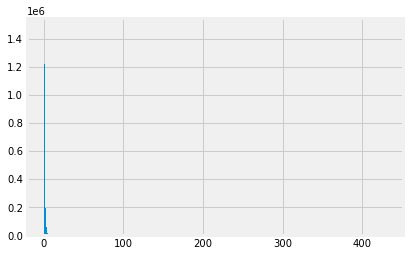

In [25]:
vv_series = pd.Series(data_sar['VV/VV'])

#vv_series[vv_series<6].hist(bins=1000)
vv_series.hist(bins=1000)
vv_series.astype(float).describe().apply("{0:.3f}".format)

count    4611250.000
mean           1.253
std            1.717
min            0.001
25%            0.645
50%            0.993
75%            1.529
max         1911.901
Name: VH/VH, dtype: object

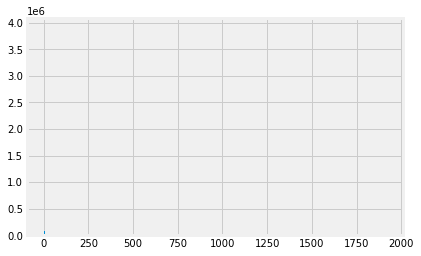

In [26]:
vh_series = pd.Series(data_sar['VH/VH'])

#vh_series[vh_series<6].hist(bins=1000)
vh_series.hist(bins=1000)
vh_series.astype(float).describe().apply("{0:.3f}".format)

In [27]:
# #### Grafico VV-VH
# sns.set(rc={'figure.figsize':(20,8)})

# sns.scatterplot(data=data_sar, x="VV/VV", y="VH/VH", hue="orbit")
# plt.show()
# sns.scatterplot(data=data_sar, x="VV/VV", y="VH/VH", hue="leak")
# plt.show()

In [28]:
wonum = data_sar["wonum"].iloc[-1]
print(wonum)

leak_vv = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==True]["VV/VV"]
leak_vh = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==True]["VH/VH"]
noleak_vv = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==False]["VV/VV"]
noleak_vh = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==False]["VH/VH"]

leak_vv = np.array(leak_vv,dtype='float').reshape(25,25)
leak_vv_norm = (leak_vv-leak_vv.min())/(leak_vv.max()-leak_vv.min())
leak_vh = np.array(leak_vh,dtype='float').reshape(25,25)
leak_vh_norm = (leak_vh-leak_vh.min())/(leak_vh.max()-leak_vh.min())

noleak_vv = np.array(noleak_vv,dtype='float').reshape(25,25)
noleak_vv_norm = (noleak_vv-noleak_vv.min())/(noleak_vv.max()-noleak_vv.min())
noleak_vh = np.array(noleak_vh,dtype='float').reshape(25,25)
noleak_vh_norm = (noleak_vh-noleak_vh.min())/(noleak_vh.max()-noleak_vh.min())

21ODL307276


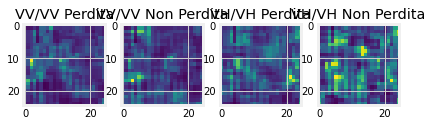

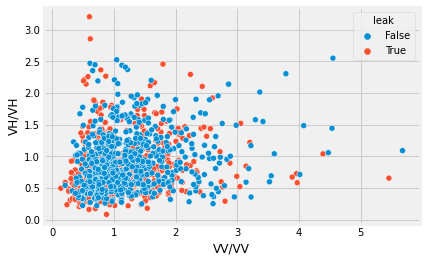

In [29]:
fig, (vv_leak, vv_noleak, vh_leak, vh_noleak) = plt.subplots(1,4)


vv_leak.set_title("VV/VV Perdita")
vv_leak.imshow(leak_vv_norm)

vv_noleak.set_title("VV/VV Non Perdita")
vv_noleak.imshow(noleak_vv_norm)

vh_leak.set_title("VH/VH Perdita")
vh_leak.imshow(leak_vh_norm)

vh_noleak.set_title("VH/VH Non Perdita")
vh_noleak.imshow(noleak_vh_norm)
plt.show()

sns.scatterplot(data=data_sar.loc[data_sar['wonum']==wonum],x="VV/VV", y="VH/VH", hue="leak")
plt.show()


In [30]:
# ### Check dell'obita di una perdita del gruppo oltre i -50
# test = data_sar.loc[data_sar['VV']<=-50].loc[data_sar['VH']<=-50]['metadata'].iloc[0]
# orbit_after = test['after']['image']['properties']['relativeOrbitNumber_start']
# orbit_before = test['before']['image']['properties']['relativeOrbitNumber_start']

# orbit_after, orbit_after2

In [31]:
# shuffle
from sklearn.utils import shuffle
X,y,m,t = shuffle(X,y,m,t,random_state=1337)

In [32]:
# save using hdf5 (so keras can easily load it) and json 
import h5py
h5file = output_dir.joinpath('data.h5')
with h5py.File(h5file, 'w') as h5f:
    h5f.create_dataset('X', data=X)
    h5f.create_dataset('y', data=y)
    h5f.create_dataset('t', data=t)

json.dump(m,open(output_dir.joinpath('data_metadata.json'),'w'))

with open(output_dir.joinpath('readme.md'),'w') as fo:
    fo. write("""
Files:
- cache- cached tiff files
- script_metadata.json - information on scraping script
- data.h5 contains X, y, and t.
    - X: tiff files for each band loaded into an array of shape (Leak, Bands, width, length)
    - y: True for before the leak, False for after
- data_metadata: array of metadata for each leak in X. Each contain info on leak, image, and image search
    
Loading: 
```py
# load
metadatas = json.load(open('data_metadata.json'))
with h5py.File('data.h5','r') as h5f:
    X2 = h5f['X'][:]
    y2 = h5f['y'][:]
    t2 = h5f['t'][:]
y
```
    """)

In [33]:
# test load
metadatas = json.load(open(output_dir.joinpath('data_metadata.json')))
with h5py.File(output_dir.joinpath('data.h5'),'r') as h5f:
    X2 = h5f['X'][:]
    y2 = h5f['y'][:]
    t2 = h5f['t'][:]
X2.shape, y2[:10], t2[:10], metadatas[0].keys()

((7378, 14, 25, 25),
 array([ True, False,  True, False, False,  True, False, False,  True,
        False]),
 array([1441517234, 1521479658, 1630733230, 1462253229, 1617383647,
        1581485255, 1535347608, 1554010018, 1515777229, 1507482806]),
 dict_keys(['after', 'before']))

In [34]:
output_dir

Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT')